Here we want to correlation ERCC concentration with log counts

In [304]:
import pandas as pd
import numpy as np
import os
from scipy.stats import linregress
import glob
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [5]:
ercc_conc_inf = "../data/cms_095046.txt"

In [64]:
expression_infs = glob.glob("/ifs/projects/toms/umi_paper/GSE65525/figures.dir/dedup_*_SRR1784317_merged_gene_counts.tsv")
print expression_infs


['/ifs/projects/toms/umi_paper/GSE65525/figures.dir/dedup_adjacency_SRR1784317_merged_gene_counts.tsv', '/ifs/projects/toms/umi_paper/GSE65525/figures.dir/dedup_unique_SRR1784317_merged_gene_counts.tsv', '/ifs/projects/toms/umi_paper/GSE65525/figures.dir/dedup_percentile_SRR1784317_merged_gene_counts.tsv', '/ifs/projects/toms/umi_paper/GSE65525/figures.dir/dedup_cluster_SRR1784317_merged_gene_counts.tsv', '/ifs/projects/toms/umi_paper/GSE65525/figures.dir/dedup_directional_adjacency_SRR1784317_merged_gene_counts.tsv']


In [7]:
ercc_conc_df = pd.read_table(ercc_conc_inf, sep="\t")
print ercc_conc_df.head()
print ercc_conc_df.columns

   Re-sort ID     ERCC ID subgroup  concentration in Mix 1 (attomoles/ul)  \
0           1  ERCC-00130        A                               30000.00   
1           2  ERCC-00004        A                                7500.00   
2           3  ERCC-00136        A                                1875.00   
3           4  ERCC-00108        A                                 937.50   
4           5  ERCC-00116        A                                 468.75   

   concentration in Mix 2 (attomoles/ul)  expected fold-change ratio  \
0                              7500.0000                         4.0   
1                              1875.0000                         4.0   
2                               468.7500                         4.0   
3                               234.3750                         4.0   
4                               117.1875                         4.0   

   log2(Mix 1/Mix 2)  
0                2.0  
1                2.0  
2                2.0  
3           

In [136]:
norm_final_df = pd.DataFrame()

def norm_counts(array):
    sum_array = sum(array)
    return [float(x)/sum_array for x in array]

for inf in expression_infs:
    method = os.path.basename(inf).split("_")[1]
    expression_df = pd.read_table(inf, sep="\t", index_col=0)

    expression_df_norm = expression_df.apply(func=norm_counts, axis=0)
    expression_df_norm_summary = expression_df_norm.ix[ercc_conc_df['ERCC ID']]
    expression_df_norm_summary['mean'] = expression_df_norm_summary.mean(axis=1)
    expression_df_norm_summary['stderr'] = (expression_df_norm_summary.std(axis=1) /
                                            np.sqrt(len(expression_df_norm_summary.columns)))
    expression_df_norm_summary.drop([x for x in expression_df_norm_summary.columns if x not in
                                     ["mean", "stderr"] ], axis=1, inplace=True)
    
    expression_df_norm_summary = pd.merge(expression_df_norm_summary, ercc_conc_df, 
                                          left_index=True, right_on="ERCC ID")
    expression_df_norm_summary['method'] = method

    norm_final_df = pd.concat([norm_final_df, expression_df_norm_summary])
    print norm_final_df.shape
    
print norm_final_df.head()

(92, 10)
(184, 10)
(276, 10)
(368, 10)
(460, 10)
       mean    stderr  Re-sort ID     ERCC ID subgroup  \
0  0.029433  0.000156           1  ERCC-00130        A   
1  0.014646  0.000089           2  ERCC-00004        A   
2  0.003910  0.000045           3  ERCC-00136        A   
3  0.002116  0.000032           4  ERCC-00108        A   
4  0.000434  0.000014           5  ERCC-00116        A   

   concentration in Mix 1 (attomoles/ul)  \
0                               30000.00   
1                                7500.00   
2                                1875.00   
3                                 937.50   
4                                 468.75   

   concentration in Mix 2 (attomoles/ul)  expected fold-change ratio  \
0                              7500.0000                         4.0   
1                              1875.0000                         4.0   
2                               468.7500                         4.0   
3                               234.3750         

          mean       stderr Re.sort.ID    ERCC.ID subgroup
1 0.0294330369 1.559534e-04          1 ERCC-00130        A
2 0.0146464006 8.941446e-05          2 ERCC-00004        A
3 0.0039097538 4.488639e-05          3 ERCC-00136        A
4 0.0021163198 3.240118e-05          4 ERCC-00108        A
5 0.0004343487 1.400936e-05          5 ERCC-00116        A
6 0.0007877370 1.987008e-05          6 ERCC-00092        A
  concentration.in.Mix.1..attomoles.ul. concentration.in.Mix.2..attomoles.ul.
1                             30000.000                            7500.00000
2                              7500.000                            1875.00000
3                              1875.000                             468.75000
4                               937.500                             234.37500
5                               468.750                             117.18750
6                               234.375                              58.59375
  expected.fold.change.ratio log2.Mix.1.M

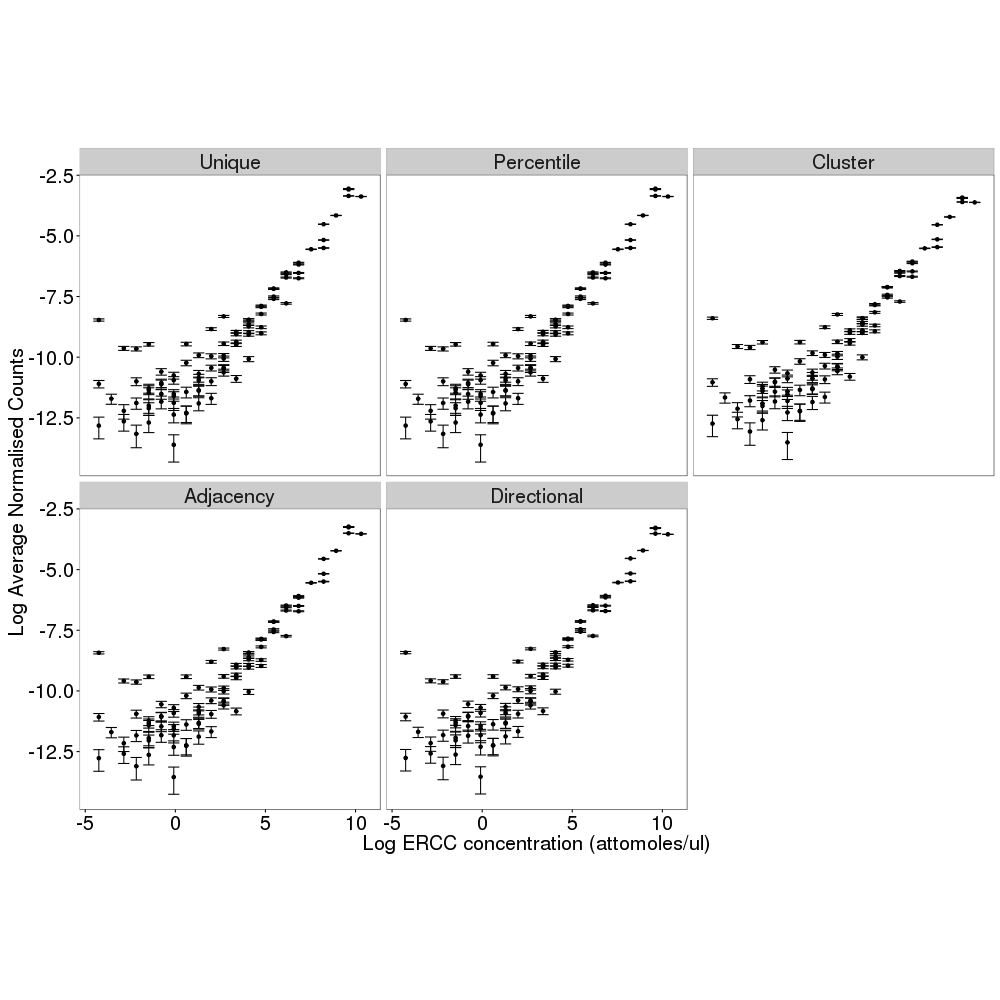

In [355]:
%%R -i norm_final_df -w 1000 -h 1000

library(ggplot2)
library(plyr)

norm_final_df$method = factor(norm_final_df$method, levels=c("unique", "percentile",
                                                   "cluster", "adjacency", "directional"))

norm_final_df$method = revalue(norm_final_df$method,c("adjacency" = "Adjacency",
                              "directional" = "Directional",
                              "cluster" = "Cluster", "percentile" = "Percentile",
                              "unique" = "Unique"))
m_txt = element_text(size=20)
s_txt = element_text(size=15)

t = theme_bw() + 
    theme(axis.text = m_txt,
          axis.title = m_txt,
          legend.title = m_txt,
          legend.text = m_txt,
          legend.key = element_blank(),
          legend.key.width=unit(1,"cm"),
          legend.key.height=unit(0.7,"cm"),
          aspect.ratio=1,
          panel.grid=element_blank(),
          strip.text = m_txt)

print(head(norm_final_df))

p = ggplot(norm_final_df,
           aes(y=log(mean), x=log(concentration.in.Mix.1..attomoles.ul.))) +
geom_point() +
geom_errorbar(aes(ymin = log(mean - stderr), ymax = log(mean + stderr))) +
facet_wrap(~method) + theme_bw() + t +
xlab("Log ERCC concentration (attomoles/ul)") +
ylab("Log Average Normalised Counts")

ggsave("../figures.dir/corr_average.png", width=12, height=8)
print(p)

In [341]:
def fit_line1(df, xcol, ycol):
    """Return slope, intercept of best fit line."""
    df = df[df[xcol]>0]
    df = df[df[ycol]>0]
    slope, intercept, r, p, stderr = linregress(np.log(df[xcol],), np.log(df[ycol]))
    return slope

def pearsonLog(df, xcol, ycol):
    df = df[df[xcol]>0]
    df = df[df[ycol]>0]
    #df[xcol] = np.log(df[xcol])
    #df[ycol] = np.log(df[ycol])
    return df[[xcol, ycol]].corr(method="pearson").iloc[0,1]

In [327]:
print pearsonLog(tmp_df, "value", "concentration in Mix 1 (attomoles/ul)")

0.893268406477


In [346]:
final_df_corr = pd.DataFrame()
final_df_slope = pd.DataFrame()

for inf in expression_infs:
    method = os.path.basename(inf).split("_")[1]
    expression_df = pd.read_table(inf, sep="\t", index_col=0)

    ercc_expression_df = expression_df.ix[ercc_conc_df['ERCC ID']]
    ercc_expression_df = pd.melt(ercc_expression_df.reset_index(), id_vars="gene")
    merged_ercc_expression_df = pd.merge(ercc_expression_df, ercc_conc_df, left_on="gene", right_on="ERCC ID")

    merged_ercc_expression_df = merged_ercc_expression_df[
        merged_ercc_expression_df["concentration in Mix 1 (attomoles/ul)"].astype(float)>1]

    corr_df = pd.DataFrame(merged_ercc_expression_df.groupby("variable").apply(
        pearsonLog, xcol="value", ycol="concentration in Mix 1 (attomoles/ul)"))

    corr_df.columns = ["corr"]
    corr_df['method'] = method
    
    slope_df = pd.DataFrame(merged_ercc_expression_df.groupby("variable").apply(
        fit_line1, xcol="value", ycol="concentration in Mix 1 (attomoles/ul)"))
    
    slope_df.columns = ["slope"]
    slope_df['method'] = method
    
    final_df_corr = pd.concat([final_df_corr, corr_df])
    final_df_slope = pd.concat([final_df_slope, slope_df])

final_df_slope.reset_index(inplace=True)
final_df_corr.reset_index(inplace=True)

print final_df_corr.head()
print final_df_slope.head()




            variable      corr     method
0  AAAACCTCCACGAAACG  0.891203  adjacency
1  AAAACGCCTTCCCAATC  0.920434  adjacency
2  AAAAGCCTAAGGTTGTG  0.875514  adjacency
3  AAAAGTCGGAAGGTAAT  0.913775  adjacency
4  AAAAGTCGGACTTCAAT  0.907566  adjacency
            variable     slope     method
0  AAAACCTCCACGAAACG  1.228555  adjacency
1  AAAACGCCTTCCCAATC  1.152002  adjacency
2  AAAAGCCTAAGGTTGTG  1.359168  adjacency
3  AAAAGTCGGAAGGTAAT  1.148297  adjacency
4  AAAAGTCGGACTTCAAT  1.408294  adjacency


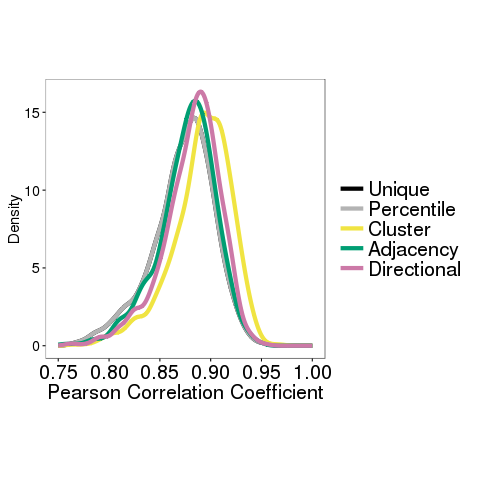

In [356]:
%%R -i final_df_corr 

library(ggplot2)
library(plyr)

gg_color_hue <- function(n) {
 colours = c("black", "grey70", "#F0E442", "#009E73", "#CC79A7",
          "#E69F00", "#0072B2", "#D55E00")
return(colours[1:n])}

final_df_corr$method = factor(final_df_corr$method, levels=c("unique", "percentile",
                                                   "cluster", "adjacency", "directional"))

final_df_corr$method = revalue(final_df_corr$method,c("adjacency" = "Adjacency",
                              "directional" = "Directional",
                              "cluster" = "Cluster", "percentile" = "Percentile",
                              "unique" = "Unique"))

m_txt = element_text(size=20)
s_txt = element_text(size=15)

t = theme_bw() + 
    theme(axis.text.x = m_txt,
          axis.title.x = m_txt,
          axis.text.y = s_txt,
          axis.title.y = s_txt,
          legend.title = m_txt,
          legend.text = m_txt,
          legend.key = element_blank(),
          legend.key.width=unit(1,"cm"),
          legend.key.height=unit(0.7,"cm"),
          aspect.ratio=1,
          panel.grid=element_blank())

p = ggplot(final_df_corr, aes(corr, colour=method)) +
stat_density(geom="line",position="identity", size=2) +
#geom_density(show_guide=FALSE, size=2) +
t +
scale_colour_manual(name="", values=c(gg_color_hue(7)[1:5])) +
xlab("Pearson Correlation Coefficient") + ylab("Density") +
scale_x_continuous(limits=c(0.75,1)) +
guides(colour = guide_legend(override.aes = list(size = 2)))
ggsave("../figures.dir/corr_density.png", width=9, height=6)
print(p)

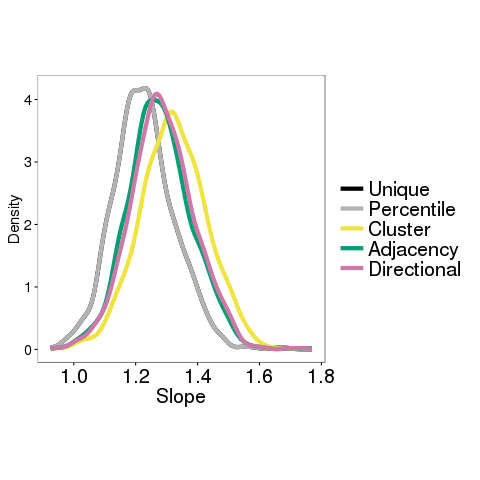

In [348]:
%%R -i final_df_slope
library(ggplot2)
library(plyr)
gg_color_hue <- function(n) {
 colours = c("black", "grey70", "#F0E442", "#009E73", "#CC79A7",
          "#E69F00", "#0072B2", "#D55E00")
return(colours[1:n])}

final_df_slope$method = factor(final_df_slope$method, levels=c("unique", "percentile",
                                                   "cluster", "adjacency", "directional"))

final_df_slope$method = revalue(final_df_slope$method,c("adjacency" = "Adjacency",
                              "directional" = "Directional",
                              "cluster" = "Cluster", "percentile" = "Percentile",
                              "unique" = "Unique"))

m_txt = element_text(size=20)
s_txt = element_text(size=15)

t = theme_bw() + 
    theme(axis.text.x = m_txt,
          axis.title.x = m_txt,
          axis.text.y = s_txt,
          axis.title.y = s_txt,
          legend.title = m_txt,
          legend.text = m_txt,
          legend.key = element_blank(),
          legend.key.width=unit(1,"cm"),
          legend.key.height=unit(0.7,"cm"),
          aspect.ratio=1,
          panel.grid=element_blank())

p = ggplot(final_df_slope, aes(slope, colour=method)) +
stat_density(geom="line",position="identity", size=2) +
#geom_density(show_guide=FALSE, size=2) +
t +
scale_colour_manual(name="", values=c(gg_color_hue(7)[1:5])) +
xlab("Slope") + ylab("Density") +
guides(colour = guide_legend(override.aes = list(size = 2)))
ggsave("../figures.dir/slope_density.png", width=9, height=6)
print(p)